# Decision Tree on the Iris Data Set

This uses a Decision Tree algorithm on the Iris flowers data set. 

Decision Trees work by splititng the data by some "attribute selection measure" which is a way of mathematically calculating the best split. Each split then becomes a decision node, repeating and creating multiple "branches" until the tree reaches uniformity at each branch or it reaches the specified depth. As such, the ending nodes of the tree (with no futher nodes sprouting from them) are called the "leaves" and tell you the class for that item.

A few notes on this:

* Is a "white box" algorotihm-- you can see the decision process of the algorithm and even visualize it in a flow-chart-like form. This is quite handy for understanding the model in such a way to make informed decisions off of it.
* Is a supervised method.
* Does not require normalization/standardization of features.
* Is prone to overfitting the data (so in practice, multiple Decision Trees tend to be aggregated, i.e. RandomForests).
* Can be biased with a very unbalanced dataset.
* Has a number of hyperparameters that can be tuned, so you might consider a grid or random search.
* Is non-parametric, i.e. it makes no assumptions about the distributions of the underlying data.
* Can also be used for regression (not covered here).



# Setting up the notebook

In [0]:
# Typical data analytics library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# SciKit learn imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Pulling in data and exploring

Let's pull in our data. We can find this one on Kaggle (https://www.kaggle.com/uciml/iris) and also on the UCI repository (link below).

In [2]:
# We're pulling in the dataset without from a source without column names, so adding those manually here
col_names = ['SepalLengthCm',	'SepalWidthCm',	'PetalLengthCm',	'PetalWidthCm', 'Species']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None, names=col_names)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Let's start by getting aquainted with the dataframe

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


No missing rows in the above, and the data types look normal. We can use the 'Species' colum for classification.

In [3]:
df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


There also does not appear to be any obvious major outliers, so we don't particularly need to treat or clean the data.

As the Decision Tree algorithm processes each feature of the data independently, there's no particular need for normalization. The data can be on completely different scales (even though the different features are roughly on the same order of magnitude here). No need to normalize.

In [0]:
# Let's look at the distribution of the different species since that is what we are trying to predict.
df.Species.value_counts()

Iris-versicolor    50
Iris-virginica     50
Iris-setosa        50
Name: Species, dtype: int64

These are all perfectly even. If one of the species was considerably over or under-represented compared to the others it could skew the distribution. In such a case we might consider weighting the voting or other techniques to resolve the issue.

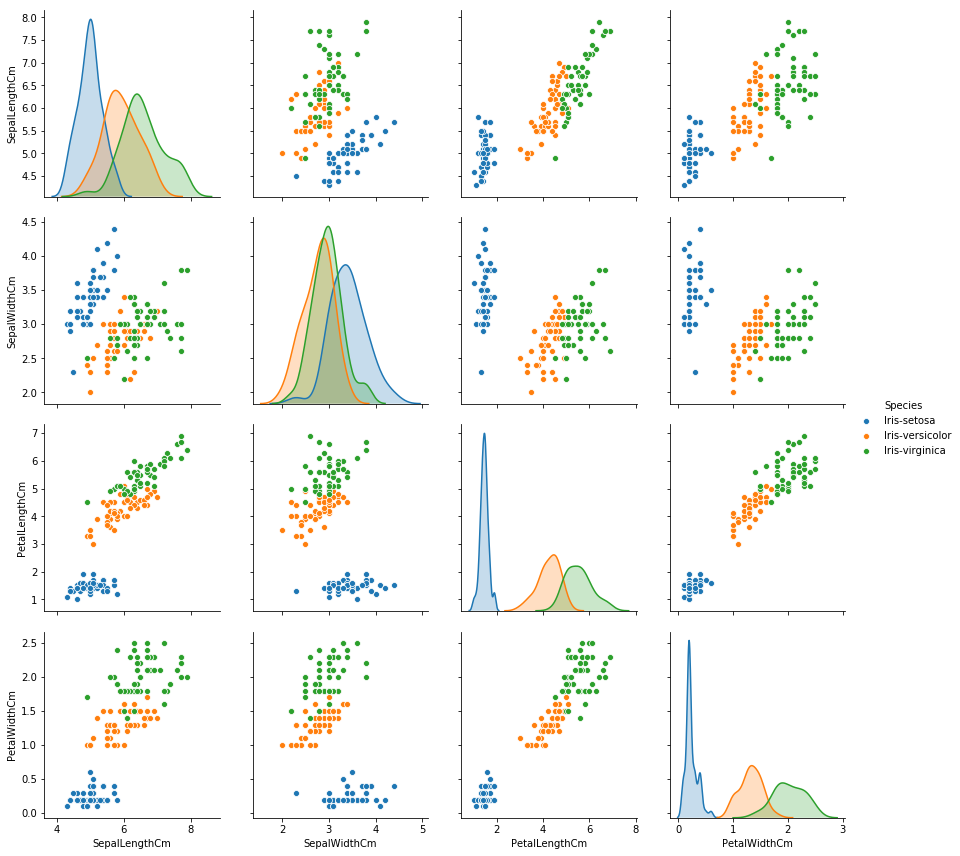

In [0]:
# Now let's look at a pair plot to get a sense of the distributions
# We also can identify which features may be useful in predicting here
sns.pairplot(data=df, hue='Species', height=3);

There are some very definite groupings here when looking at the relationships. A Decision Tree should be able to split the data fairly accuratley.

# Setting up data for the ML algorithm

In [0]:
# Defining our features to predict by (our "X")
features = ['PetalLengthCm', 	'PetalWidthCm', 'SepalLengthCm', 'SepalWidthCm']
X = df[features]

# And our target (our "y")
y = df['Species']

In [4]:
# Now we need to split our data into a set to train on, and a set to test on
# test_size means the test set will be 20% of the original data (and the train %80). This is conventional but arbitrary
# random_state defines the seed for the random split so that you can get the same each time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# We'll print out the shape of each set also so that we know it worked fine
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((120, 4), (120,), (30, 4), (30,))

The X sets should have the same row count as the Y sets, and we should see 4 features in the X sets since we're looking at 4 columns of data. Worked fine.

# Optimizing parameters

## GridSearch of Typical Hyperparameters

Decision Trees have a number of possible hyperparameters that can be tuned to improve a model. We're going to focus on just a few of them here:

* `max_depth` - How deep the tree can go in terms of number of splits. Can be anywhere 1 to "None" (no max depth). If no max depth, the tree terminates based on 100% purity or other parameters.
* `min_samples_split` - The minimum number of samples that must at least be in a node before it can be split. Default is generally 2. So for instance, if this was set to 4, but a node had 3 samples within it, it would not be allowed to be split any further.
* `min_samples_leaf` - The minimum number of samples to be considered a leaf node. Default is 1. This parameter won't allow a leaf node to form unless it has at least this number.
* `criterion` - This chooses the method the Decision Tree classifer uses to make each split. The support methods are "gini" for impurity and "entropy" for information gain.
 * Entropy and information gain - This measures the decrease in entropy (i.e. the gain in information) mathematically that would happen via a particular split. So the attribute with the highest information gain is chosen as the splitting attribute at any given node. Analagous to entropy in thermodynamics.
 * Gini and impurity - Here the calculation is given by a "gini index" which is based on probabilities, but it's very similar in that the attribute with the minimum Gini index is chosen for the split.
 * Choosing between the two - Gini favors larger partitions some while Entropy favors smaller splits with more unique values. Ultimately you might want to run both to see. Speed-wise entropy can possibly be slower, but in most cases, not that much.

As there are multiple parameters, we'll use `GridSearchCV` to search through each and faind the best possible combination. This can be computationally expensive and, as such, we might choose to use a quicker (but less exhaustive) method like `RandomizedSearchCV`. However, for this small dataset, we don't mind going through a few of them. GridSearchCV automatically implements [cross validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) via the "cv" parameter, so we don't need to worry about this separately. This is particularly useful to make sure we're not overfitting our model through parameter tuning.

In [7]:
# Set up a grid of different parameters we'd like to search over
# These were somewhat arbitrarily chosen based on the characteristics of the datset
param_distribution = {'max_depth': [1, 2, 3, None],
                      'min_samples_split': [2, 3, 4, 5, 7, 9],
                      'min_samples_leaf': [1, 2, 3, 4, 5, 7, 9],
                      'criterion': ["gini", "entropy"]}

# Initializing the classifier
tree = DecisionTreeClassifier()

# Creating the GridSearch object
tree_grid_search = GridSearchCV(tree, param_distribution, cv=10) # Remember GridSearch includes cross-validation through "cv", so 10-fold here

# Fit the grid search onto our training data
tree_grid_search.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [8]:
# We can acess the best parameters from the search via the attribute below
tree_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [9]:
# And similar we can access the score using those parameters
tree_grid_search.best_score_

# We could also access the results directly with the attribute cv_results_,
# but even in this case the number of combinations would be particularly large

0.9583333333333334

## Other optimizations

### Further parameters

There are a number of other parameters you can set for Decision Trees not covered here (not all important). See below:

In [11]:
tree.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

### Pruning

Another way to tune a tree is with the consideration of "pruning." The idea is that that it's hard to know how when to stop tree depth, as it's not always easy to tell whether the addition of another node will add extra error. One way to approach this is to let the tree run to max-depth and then prune off end nodes that don't actually add any additional useful information. In this case, this method isn't needed as Sklearn's Decision Tree classifier implements pre-pruning through the `max_depth` hyperparameter.

# Implementing the model

In [0]:
# Now we will rebuild our tree classifier with the parameters we dicovered from the search
tree = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=1, min_samples_split=2)

# And fit it to our training data
tree.fit(X_train, y_train);

# Testing accuracy

In [13]:
# Now let's check out how accurate our model was with a basic accuracy score

train_accuracy = tree.score(X_train, y_train)
test_accuracy = tree.score(X_test, y_test)

print(train_accuracy, test_accuracy)

0.9666666666666667 0.9333333333333333


The accuracy looks pretty good and only decreases slightly on the test set. It does not appear to have overfit the training data *too* much here at least.

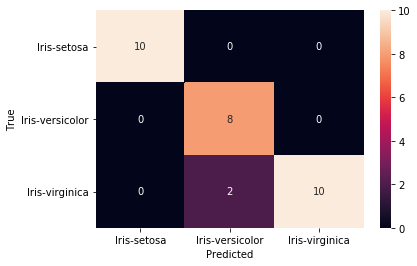

In [15]:
# Another way to look at the results is a confusion matrix, we'll set that up here
# The net result will be a grid of how the correct and incorrect predictions distributed out

# First we need to set up a predicted output
prediction = tree.predict(X_test)

# The function we will use takes some labelling, so let's list out our possible answers
cm_labels = np.unique(df['Species'].values).tolist()

# The function itself comes from SKlearn
cfn_matrix = confusion_matrix(y_test, prediction, labels=cm_labels)

# We can turn our matrix into a pandas dataframe for easier manipulation and labelling
df_cm = pd.DataFrame(cfn_matrix, index=cm_labels, columns=cm_labels)

# Finally this can be plotted as a heatmap to get a decent visual
sns.heatmap(df_cm, annot=True)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

This is effectively like a pair-plot of each target class against itself. As such higher scores on the diagonal mean the values were correctly predicted. Any off-diagonal numbers tell you what was predicted instead of the correct value.

Here we can see that two which weere actually virginica were incorrectly determined to be versicolors.

In [16]:
# Finally SKlearn also has a classification report to get extra details about how well the model worked

print(classification_report(y_test, prediction))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.80      1.00      0.89         8
 Iris-virginica       1.00      0.83      0.91        12

       accuracy                           0.93        30
      macro avg       0.93      0.94      0.93        30
   weighted avg       0.95      0.93      0.93        30



# Displaying the Tree

One nice thing about Decision Trees is that they are a white-box algorithm. As such, we can actually take a look at our tree and how the predictions were made. There are a couple of handy code imports for that.

In the code below `export_graphviz` converts our Decision Tree classifier into a dot file and `pydotplus` in conjunction with `Image` convert this dot file to png. (This was a copy-paste from a few locations online with the code beyond the score covered here)

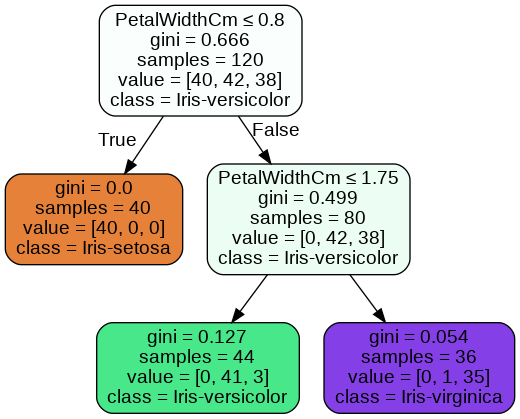

In [20]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

# Setting up a classes list to pass to the export
classes = np.unique(df['Species'].values).tolist()

export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=classes)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

In the above, the "values" output tells how many observations of each class (flower type) fell into that node on prediction. "Class" details the majority predicted class at that node. Handy!

# Example single test

In [23]:
# The .predict() method expects an array of arrays, so we need to know how to input the ordered data
# Let's look at a row to see the order and get an example of the possible kinds of data used
X_test.head(1)

,PetalLengthCm,PetalWidthCm,SepalLengthCm,SepalWidthCm
4,1.4,0.2,5.0,3.6


In [24]:
# And now let's input some new data to get the prediction
# We can also report out the probability for that number

new_data = [2, 0.5, 3, 4]

# Note that this ends up with double brackets so that it is indeed making an array of arrays
tree.predict([new_data]), tree.predict_proba([new_data])

(array(['Iris-setosa'], dtype=object), array([[1., 0., 0.]]))

Note that the predict_proba is providing the probability for each of the possible target classes rather than the probability that the prediction is accuracte. The output order is lexicographic.

In [26]:
# The new data used was very similar to the row printed out above, so let's see if we get the same prediction if using the actual row data

tree.predict([[1.4, 0.2, 5, 3.6]])

array(['Iris-setosa'], dtype=object)

This all seems to work pretty well. We could now train our model on the whole set using our determined parameters and then package the model for further use.